The news articles dataset has been obtained from Kaggle. 
This is the url: https://www.kaggle.com/pariza/bbc-news-summary

In [4]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab 
import seaborn as sns

In [5]:
import spacy
from spacy import displacy
from spacy.lang.en.stop_words import STOP_WORDS
import os
import gensim

from gensim.models import CoherenceModel, LdaModel, LsiModel, HdpModel
from gensim.corpora import Dictionary
import pyLDAvis.gensim

In [6]:
nlp = spacy.load('en_core_web_lg')

At the time of doing this project (25/12/2018), spacy's english language model (en_core_web_lg) has problem in recognizing stop words. This can be seen in the following example.

In [7]:
doc = nlp('This is a sentence. And the cat jumped over the dog. The cat returned as the prisoner of Azkaban.')
for token in doc:
    print(token.text, token.is_stop)

This False
is False
a False
sentence False
. False
And False
the False
cat False
jumped False
over False
the False
dog False
. False
The False
cat False
returned False
as False
the False
prisoner False
of False
Azkaban False
. False


As you can see above, it doesn't recognize 'This', 'is', 'a', 'the', etc. as stop words, we are going to address this issue, by the following steps.

In [8]:
for stop_word in STOP_WORDS:
    for word in (stop_word, stop_word.capitalize(), stop_word.upper()):
        lex = nlp.vocab[word]
        lex.is_stop = True

Let us recheck the above scenario again and see whether the model is recognizing stop words or not.

In [9]:
doc = nlp('This is a sentence. And the cat jumped over the dog. The cat returned as the prisoner of Azkaban.')
for token in doc:
    print(token.text, token.is_stop)

This True
is True
a True
sentence False
. False
And True
the True
cat False
jumped False
over True
the True
dog False
. False
The True
cat False
returned False
as True
the True
prisoner False
of True
Azkaban False
. False


We are going to analyze the news articles. Let us look at a sample news article.

In [10]:
with open('BBC News Summary/News Articles/politics/001.txt', 'r') as news_file:
    newsArticle = news_file.read()
    newsArticle = newsArticle.replace('\n', ' ')
    print(newsArticle)

Labour plans maternity pay rise  Maternity pay for new mothers is to rise by Â£1,400 as part of new proposals announced by the Trade and Industry Secretary Patricia Hewitt.  It would mean paid leave would be increased to nine months by 2007, Ms Hewitt told GMTV's Sunday programme. Other plans include letting maternity pay be given to fathers and extending rights to parents of older children. The Tories dismissed the maternity pay plan as "desperate", while the Liberal Democrats said it was misdirected.  Ms Hewitt said: "We have already doubled the length of maternity pay, it was 13 weeks when we were elected, we have already taken it up to 26 weeks. "We are going to extend the pay to nine months by 2007 and the aim is to get it right up to the full 12 months by the end of the next Parliament." She said new mothers were already entitled to 12 months leave, but that many women could not take it as only six of those months were paid. "We have made a firm commitment. We will definitely ext

We are going to start with the named entity recognition (NER) of the text document. NER is helpful in identifying geographical location, name of persons, organization, etc. in a textual document. Spacy's list of named entities can be foun here: https://spacy.io/api/annotation#named-entities

In [11]:
newsDoc = nlp(newsArticle)

In [12]:
for ent in newsDoc.ents:
    print(ent.text, ent.label_)

Â£1,400 ORG
the Trade and Industry ORG
Patricia Hewitt PERSON
nine months by 2007 DATE
Ms Hewitt PERSON
GMTV ORG
Sunday DATE
Tories NORP
Liberal NORP
Democrats NORP
Ms Hewitt PERSON
13 weeks DATE
up to 26 weeks DATE
nine months by 2007 DATE
the full 12 months DATE
the end of the next Parliament DATE
12 months DATE
months DATE
the six months DATE
is to nine months DATE
Â£1,400 PERSON
State ORG
Family PRODUCT
Theresa ORG
May DATE
Gordon Brown PERSON
December DATE
Tony Blair PERSON
Conservatives ORG
Democrat NORP
Sandra Gidley PERSON
the Liberal Democrats ORG
the first six months DATE
Ms Hewitt PERSON
David Frost PERSON
the British Chambers of Commerce ORG
Monday DATE
90% PERCENT
the first six weeks DATE
Â£102.80 a week DATE
six months old DATE


we can visualize the entities in the document using displacy

In [13]:
displacy.render(newsDoc, style='ent', jupyter=True)

Spacy is able to recognize most of the entities correctly, but as we can see above there a few places it is incorrect

For example, if we want to redact the name of persons from classified documents, manually doing it would be time consuming and requirement of lot of human resources. We can solve this by building a robust NER system, which can redact documents containing sensitive information. Let us do this in an example here. Let us take the above news article and redact all the names of person from it.

In [14]:
def getRedactedDoc(doc):

    tokens = []
    for ent in doc.ents:
        ent.merge()
        
    for token in doc:
        if token.ent_type_ == "PERSON":
            tokens.append("[REDACTED]")
        else:
            tokens.append(token.string)
            
    return "".join(tokens)

In [15]:
getRedactedDoc(newsDoc)

'Labour plans maternity pay rise  Maternity pay for new mothers is to rise by Â£1,400 as part of new proposals announced by the Trade and Industry Secretary [REDACTED].  It would mean paid leave would be increased to nine months by 2007, [REDACTED]told GMTV\'s Sunday programme. Other plans include letting maternity pay be given to fathers and extending rights to parents of older children. The Tories dismissed the maternity pay plan as "desperate", while the Liberal Democrats said it was misdirected.  [REDACTED]said: "We have already doubled the length of maternity pay, it was 13 weeks when we were elected, we have already taken it up to 26 weeks. "We are going to extend the pay to nine months by 2007 and the aim is to get it right up to the full 12 months by the end of the next Parliament." She said new mothers were already entitled to 12 months leave, but that many women could not take it as only six of those months were paid. "We have made a firm commitment. We will definitely extend

The news articles are grouped into 5 categories: sport, tech, politics, entertainment and business. Let's print a sample article from each category.

In [16]:
news_categories = ['sport', 'tech', 'politics', 'entertainment', 'business']
base_directory = 'BBC News Summary/News Articles/'

In [17]:
for category in news_categories:
    with open(base_directory + category + '/001.txt', 'r') as news_file:
        newsArticle = news_file.read()
        #we are going to print the first 400 characters of the article
        print('Category', category.capitalize())
        print('\n')
        if len(newsArticle) > 400:
            print(newsArticle[0:400] + '...')
        else:
            print(newsArticle)
        print('\n')

Category Sport


Claxton hunting first major medal

British hurdler Sarah Claxton is confident she can win her first major medal at next month's European Indoor Championships in Madrid.

The 25-year-old has already smashed the British record over 60m hurdles twice this season, setting a new mark of 7.96 seconds to win the AAAs title. "I am quite confident," said Claxton. "But I take each race as it comes. "As long...


Category Tech


Ink helps drive democracy in Asia

The Kyrgyz Republic, a small, mountainous state of the former Soviet republic, is using invisible ink and ultraviolet readers in the country's elections as part of a drive to prevent multiple voting.

This new technology is causing both worries and guarded optimism among different sectors of the population. In an effort to live up to its reputation in the 1990s a...


Category Politics


Labour plans maternity pay rise

Maternity pay for new mothers is to rise by Â£1,400 as part of new proposals announced by the Trade an

Let us count the number of news articles in each category.

In [25]:
num_articles_categorywise = []
news_articles_capitalized = []

In [26]:
for category in news_categories:
    num_articles = len([file for file in os.listdir(base_directory + category) if file.endswith(".txt")])
    #print('Category:', category.capitalize(), ',' ,'Number of Articles:', num_articles)
    news_articles_capitalized.append(category.capitalize())
    num_articles_categorywise.append(num_articles)

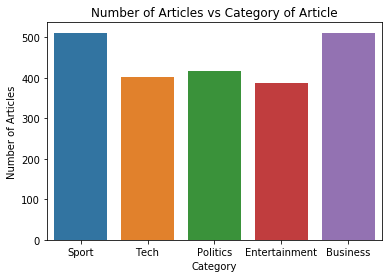

In [29]:
articles_df = pd.DataFrame({'Category':news_articles_capitalized, 'Number of Articles': num_articles_categorywise})
ax1 = sns.barplot(x="Category", y="Number of Articles", data=articles_df).set_title('Number of Articles vs Category of Article')

We will be doing the topic modelling of the new articles. We will be using the gensim package for topic modelling. The different algorithms that we will be looking at:
1. Hierarchical Dirichlet Process (HDP)
2. Latent Dirichlet Allocation (LDA)
3. Latent Semantic Indexing (LSI)

In the case of news articles that are quite frequent, and can be put in the stopwords of the sapcy package

In [52]:
custom_stop_words = ['say', 'says', 'said', 'saying', '\'s', 'n\'t','mr', 'ms', 'mr.', 'ms.', 'people']
for stop_word in custom_stop_words:
    for word in (stop_word, stop_word.capitalize(), stop_word.upper()):
        lex = nlp.vocab[word]
        lex.is_stop = True

In [53]:
def create_corpus_for_topic_modelling():
    
    news_corpus = []
    category_words_dict = {}
    
    for category in news_categories:
        
        category_words_dict[category] = {}
        en_directory = os.fsencode(base_directory + category)
        count_articles = 0

        for file in os.listdir(en_directory):

            fileName = os.fsdecode(file)

            if fileName.endswith(".txt"):

                count_articles += 1

                if count_articles > 300:
                    break

                cur_article = []

                with open(base_directory + category + '/' + fileName, 'r') as news_file:

                    newsArticle = news_file.read()
                    newsArticle = newsArticle.replace('\n', ' ')
                    newsArticle = newsArticle.lower()
                    doc = nlp(newsArticle)

                    for token in doc:

                        if token.lemma_ != '-PRON-' and len(token.lemma_) > 1 and not token.is_space and not token.is_stop and not token.is_punct and not token.like_num and not token.like_email and not token.like_url:

                            # For topic modelling lemmatized version of the word is preferable for better results
                            cur_article.append(token.lemma_)
                            category_words_dict[category][token.text] = category_words_dict[category].get(token.text, 0) + 1
                            

                news_corpus.append(cur_article)
                
                
    return (news_corpus, category_words_dict)
       

We will be using 200 articles from each news category for topic modelling

In [54]:
(news_corpus, category_words_dict) = create_corpus_for_topic_modelling()

In [55]:
print(len(news_corpus))

1500


In [88]:
sns.set(font_scale=1.5)
pylab.rcParams['figure.figsize'] = 18, 6

In [91]:
def generate_word_count_bar_chart(word_dict, category):
    #print('category name', category)
    word_count_list = sorted(list(word_dict.items()), reverse=True, key=lambda word: word[1])[0:40]
    word_count_df = pd.DataFrame(word_count_list, columns=['Word', 'Count'])
    ax = sns.barplot(x="Word", y="Count", data=word_count_df)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=60)
    ax.set_title('Most frequent words in the ' + category + ' category')
    plt.show()
    #print(word_count_df.head())
    

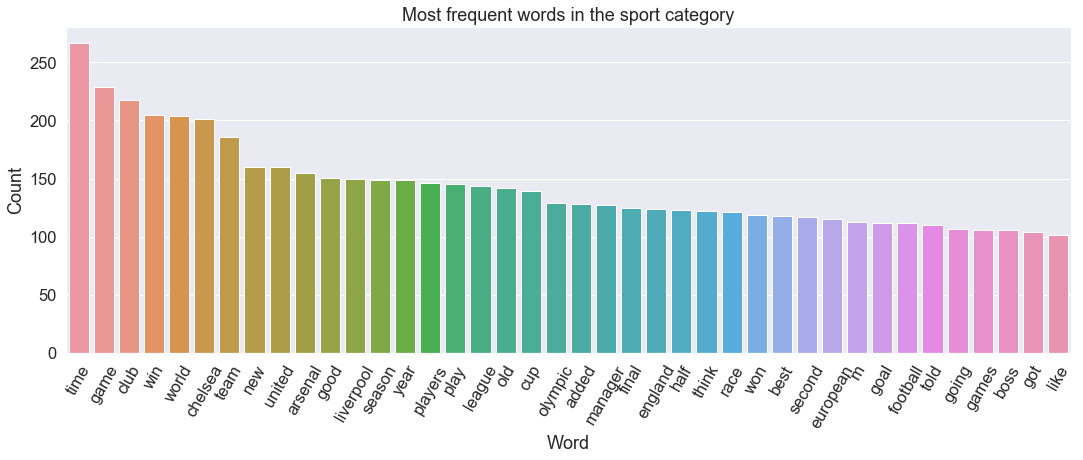

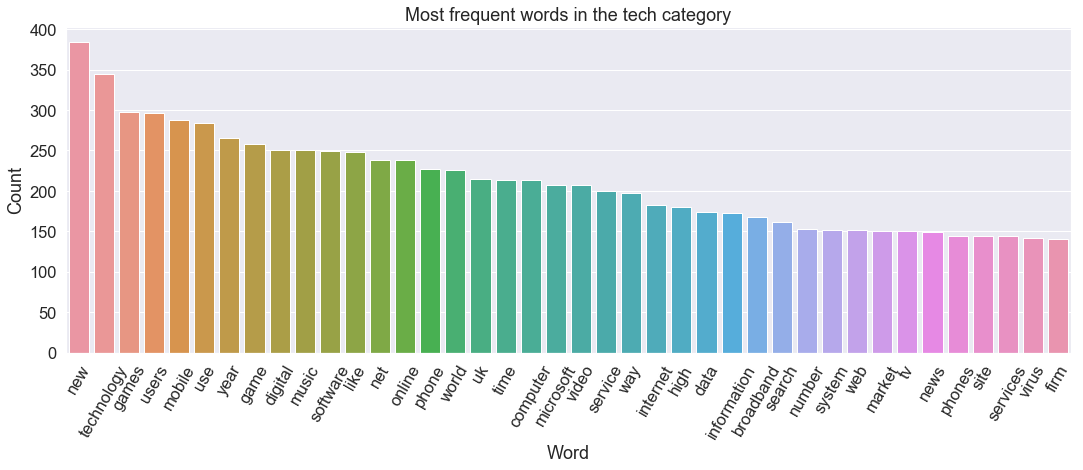

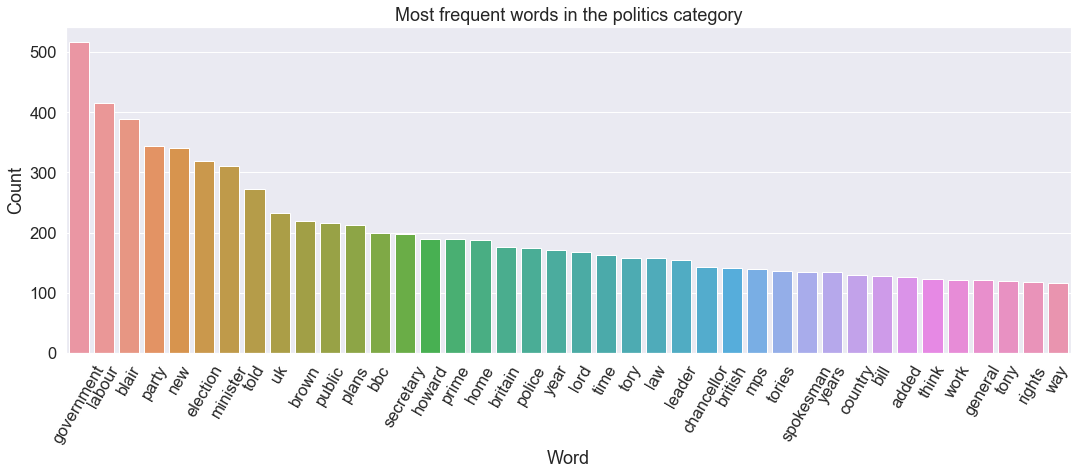

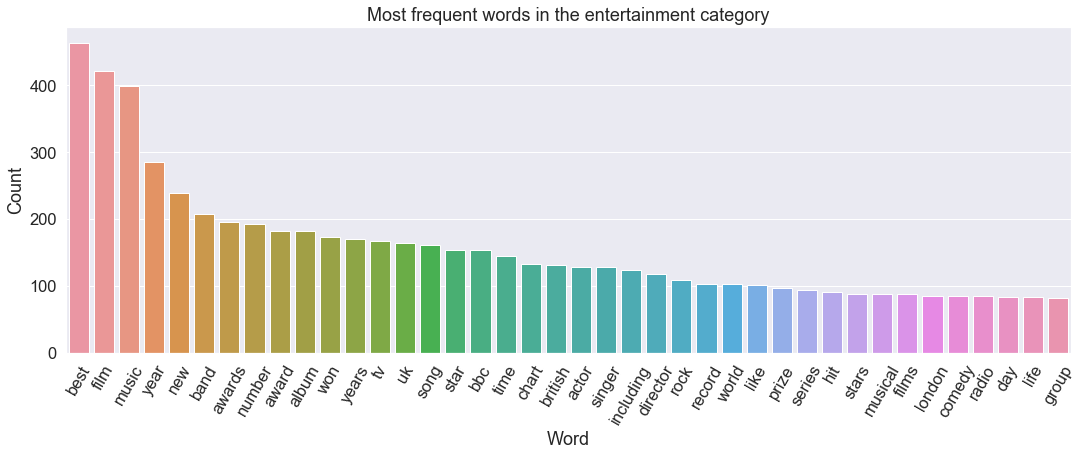

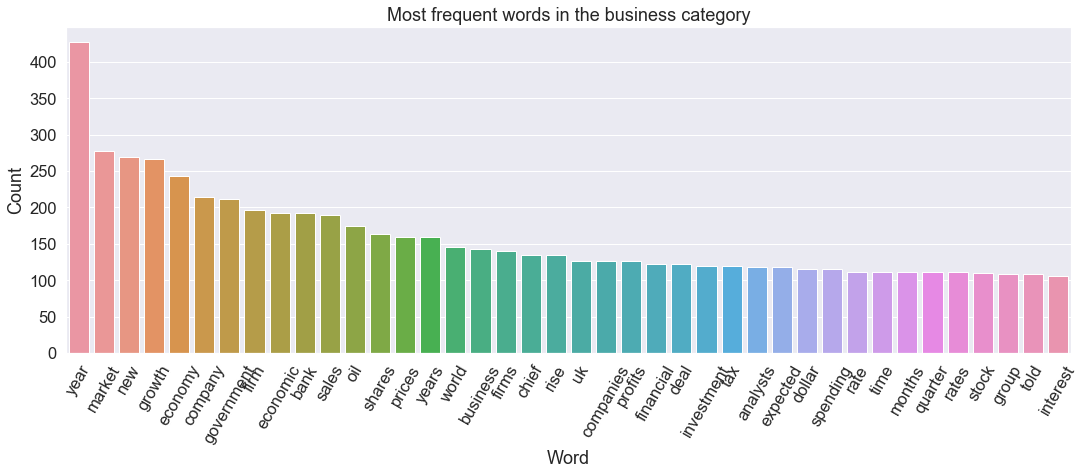

In [92]:
for category in news_categories:
    generate_word_count_bar_chart(category_words_dict[category], category)

After going through the above bar charts, we can add some words to the stop list as they won't add much value during topic modelling

In [95]:
custom_stop_words_from_analysis = ['bbc', 'new', 'year', 'years', 'told', 'got', 'like', 'm']
for stop_word in custom_stop_words_from_analysis:
    for word in (stop_word, stop_word.capitalize(), stop_word.upper()):
        lex = nlp.vocab[word]
        lex.is_stop = True

Let us once confirm whether the words have been successfully removed or not

In [96]:
(news_corpus, category_words_dict) = create_corpus_for_topic_modelling()

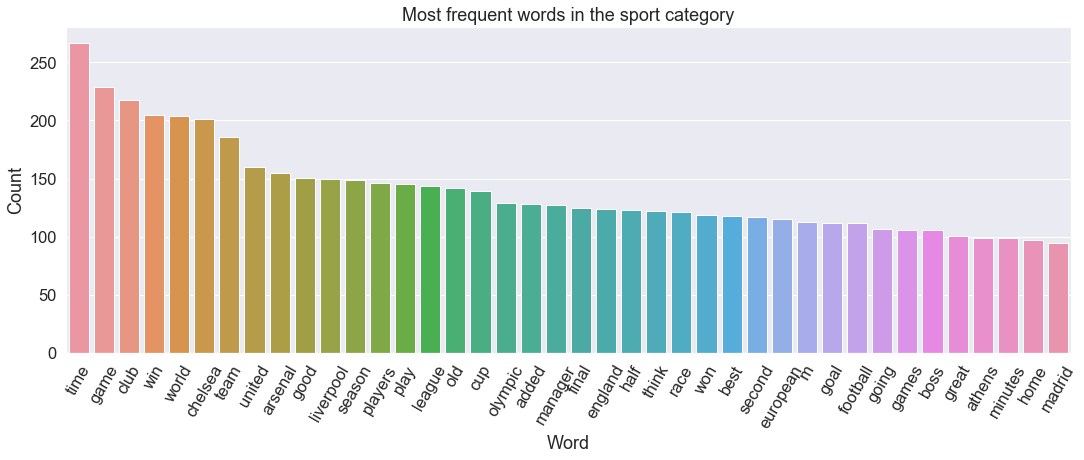

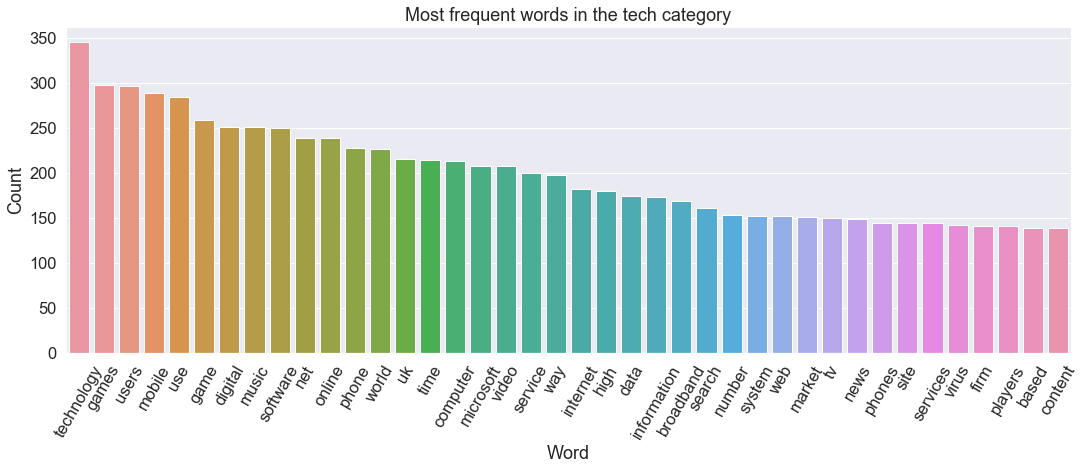

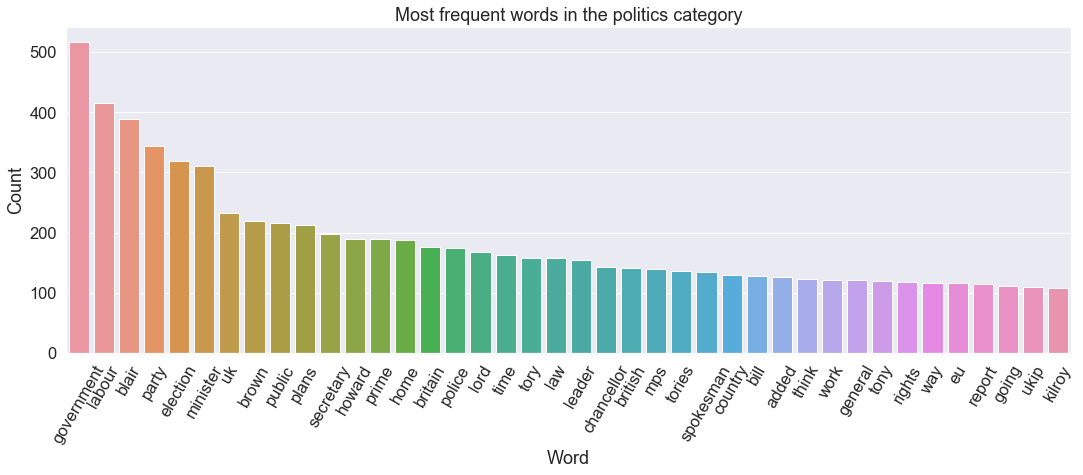

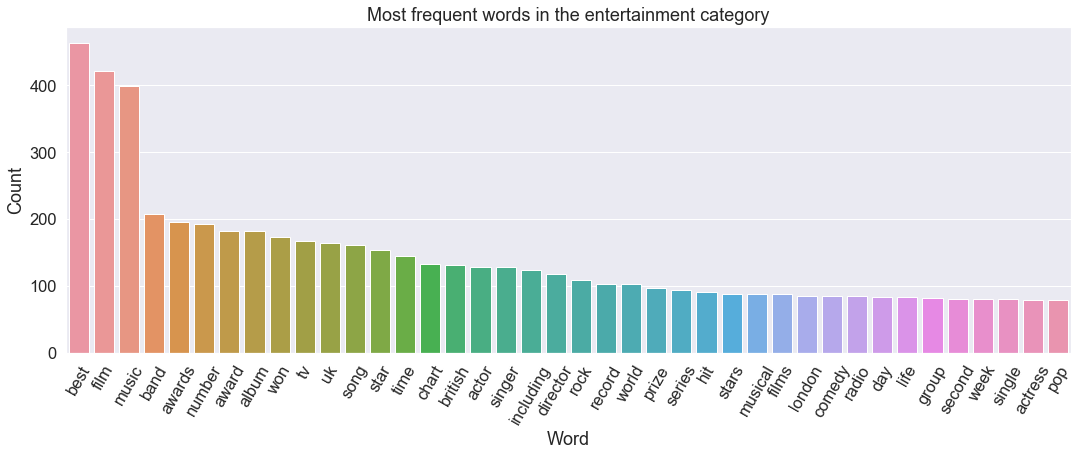

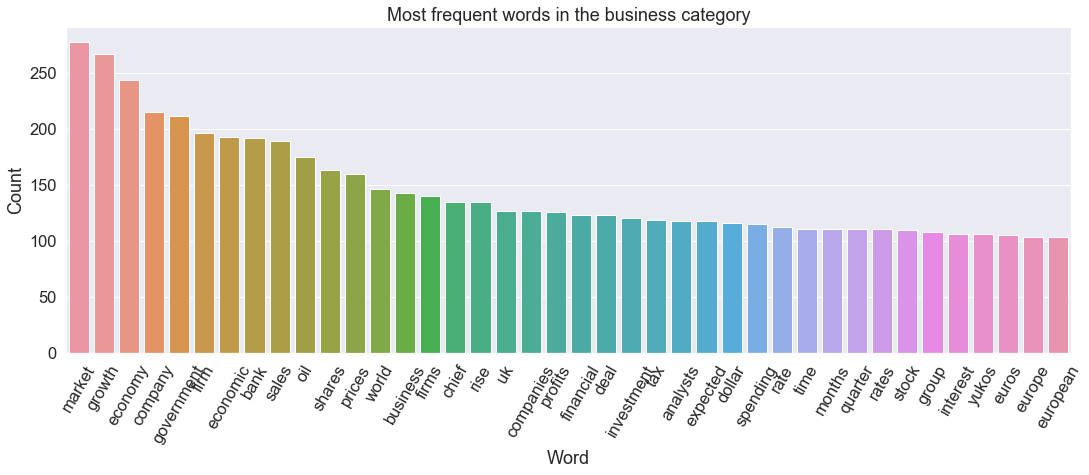

In [97]:
for category in news_categories:
    generate_word_count_bar_chart(category_words_dict[category], category)

In [98]:
for i in (2, 302, 602, 902, 1202):
    print(news_corpus[i])
    print('\n')

['greene', 'set', 'sight', 'world', 'title', 'maurice', 'greene', 'aim', 'wipe', 'pain', 'lose', 'olympic', 'title', 'athen', 'win', 'fourth', 'world', 'championship', 'crown', 'summer', 'settle', 'bronze', 'greece', 'fellow', 'american', 'justin', 'gatlin', 'francis', 'obikwelu', 'portugal', 'hurt', 'look', 'medal', 'mistake', 'lose', 'thing', 'greene', 'race', 'birmingham', 'friday', 'go', 'happen', 'goal', 'be', 'go', 'win', 'world', 'greene', 'cross', 'line', 'second', 'gatlin', 'win', 'second', 'close', 'fast', 'sprint', 'time', 'greene', 'believe', 'lose', 'race', 'title', 'semi', 'final', 'semi', 'final', 'race', 'win', 'race', 'conserve', 'energy', 'francis', 'obikwelu', 'come', 'take', 'know', 'believe', 'lane', 'final', 'lane', 'feel', 'race', 'feel', 'run', 'believe', 'middle', 'race', 'able', 'react', 'come', 'ahead', 'greene', 'deny', 'olympic', 'gold', '4x100', 'man', 'relay', 'catch', 'britain', 'mark', 'lewis', 'francis', 'final', 'leg', 'kansas', 'star', 'set', 'head',

In [99]:
bigram = gensim.models.Phrases(news_corpus)

In [100]:
news_corpus = [bigram[cur_article] for cur_article in news_corpus]

In [102]:
print(news_corpus[302])

['microsoft', 'seek', 'spyware', 'trojan', 'microsoft', 'investigate', 'trojan', 'program', 'attempt', 'switch', 'firm', 'anti_spyware', 'software', 'spyware_tool', 'release', 'microsoft', 'week', 'download', 'stephen', 'toulouse', 'security', 'manager', 'microsoft', 'malicious_program', 'call', 'bankash', 'trojan', 'send_mail', 'attachment', 'microsoft', 'believe', 'program', 'widespread', 'recommend', 'user', 'use', 'anti_virus', 'program', 'program', 'attempt', 'disable', 'delete', 'microsoft', 'anti_spyware', 'tool', 'suppress', 'warning', 'message', 'give', 'user', 'try', 'steal', 'online', 'banking', 'password', 'personal_information', 'track', 'user', 'keystroke', 'microsoft', 'statement', 'investigate', 'call', 'criminal', 'attack', 'software', 'earlier_week', 'microsoft', 'buy', 'anti_virus', 'software', 'maker', 'sybari', 'software', 'improve', 'security', 'window', 'mail', 'software', 'microsoft', 'plan', 'offer', 'pay', 'anti_virus', 'software', 'set', 'date', 'release', 'a

In [103]:
dictionary = Dictionary(news_corpus)
print(dictionary)

Dictionary(20833 unique tokens: ['25-year_old', 'aaas_title', 'athlete', 'attention', 'bear']...)


In [104]:
corpus_for_modelling = [dictionary.doc2bow(cur_article) for cur_article in news_corpus]

In [105]:
print(corpus_for_modelling[2])

[(5, 1), (12, 5), (14, 1), (20, 1), (25, 1), (39, 1), (49, 6), (55, 1), (56, 3), (57, 1), (65, 1), (66, 2), (67, 4), (69, 1), (73, 4), (74, 4), (85, 1), (96, 1), (117, 1), (127, 1), (128, 1), (129, 1), (130, 1), (131, 1), (132, 1), (133, 1), (134, 1), (135, 1), (136, 1), (137, 1), (138, 4), (139, 1), (140, 1), (141, 1), (142, 1), (143, 1), (144, 1), (145, 1), (146, 1), (147, 2), (148, 1), (149, 1), (150, 1), (151, 1), (152, 1), (153, 2), (154, 1), (155, 2), (156, 1), (157, 1), (158, 3), (159, 2), (160, 3), (161, 1), (162, 1), (163, 1), (164, 8), (165, 1), (166, 1), (167, 1), (168, 1), (169, 1), (170, 1), (171, 1), (172, 1), (173, 1), (174, 1), (175, 1), (176, 2), (177, 1), (178, 1), (179, 1), (180, 3), (181, 1), (182, 1), (183, 1), (184, 1), (185, 1), (186, 1), (187, 1), (188, 2), (189, 1), (190, 1), (191, 1), (192, 1), (193, 1), (194, 1), (195, 1), (196, 1), (197, 1), (198, 1), (199, 1), (200, 1), (201, 2), (202, 1), (203, 1), (204, 1), (205, 1), (206, 1), (207, 1), (208, 1), (209, 1)

We are going to start with the Hierarchical Dirichlet Process (HDP) Topic Modelling Algorithm. In HDP, we don't need to specify the number of topics. The algorithm is able to deduce the best "number of topics" for a given text corpus.

In [106]:
hdpModel = HdpModel(corpus=corpus_for_modelling, id2word=dictionary)

In [107]:
hdpModel.show_topics()

[(0,
  '0.004*government + 0.003*company + 0.003*time + 0.003*firm + 0.003*good + 0.003*rise + 0.003*uk + 0.003*market + 0.002*music + 0.002*work + 0.002*sale + 0.002*add + 0.002*come + 0.002*go + 0.002*report + 0.002*plan + 0.002*need + 0.002*country + 0.002*think + 0.002*want'),
 (1,
  '0.004*good + 0.003*time + 0.003*win + 0.003*number + 0.003*game + 0.002*come + 0.002*play + 0.002*group + 0.002*go + 0.002*take + 0.002*film + 0.002*look + 0.002*think + 0.002*world + 0.002*work + 0.002*include + 0.001*labour + 0.001*uk + 0.001*big + 0.001*know'),
 (2,
  '0.003*party + 0.003*game + 0.003*good + 0.003*time + 0.002*ukip + 0.002*want + 0.002*technology + 0.002*include + 0.002*come + 0.002*number + 0.002*play + 0.002*work + 0.002*chart + 0.002*award + 0.002*company + 0.002*sale + 0.002*kilroy_silk + 0.002*film + 0.002*go + 0.002*country'),
 (3,
  '0.003*government + 0.002*film + 0.002*plan + 0.002*work + 0.002*good + 0.002*include + 0.002*time + 0.002*think + 0.002*labour + 0.002*minister

In [108]:
hdp_coherence_model = CoherenceModel(model=hdpModel, texts=news_corpus, dictionary=dictionary, coherence='c_v')
hdp_coherence = hdp_coherence_model.get_coherence()
print(hdp_coherence)

0.549230551538534


Next, we are going to proceed with the Latent Dirichlet Allocation model, here we need to pass the number of topics. Based on the coherence score, we can deduce the best "number of topics".

In [109]:
list_num_of_topics = [10, 15, 20, 25, 30]
for num_topics in list_num_of_topics:
    ldaModel = LdaModel(corpus=corpus_for_modelling, num_topics=num_topics, id2word=dictionary)
    coherenceModel = CoherenceModel(model=ldaModel, texts=news_corpus, dictionary=dictionary, coherence='c_v')
    print('Number of Topics', num_topics)
    print('Coherence Value', coherenceModel.get_coherence())

Number of Topics 10
Coherence Value 0.22718658510428366
Number of Topics 15
Coherence Value 0.24082760817033802
Number of Topics 20
Coherence Value 0.23173863298767242
Number of Topics 25
Coherence Value 0.23778312529348342
Number of Topics 30
Coherence Value 0.24772315404088863


In [110]:
ldaModel_best = LdaModel(corpus=corpus_for_modelling, num_topics=30, id2word=dictionary)
ldaModel_best.show_topics(30)

[(0,
  '0.008*"film" + 0.004*"uk" + 0.004*"time" + 0.004*"good" + 0.003*"take" + 0.003*"play" + 0.003*"think" + 0.003*"add" + 0.003*"award" + 0.003*"win"'),
 (1,
  '0.005*"film" + 0.005*"good" + 0.004*"time" + 0.004*"technology" + 0.004*"come" + 0.003*"include" + 0.003*"uk" + 0.003*"win" + 0.003*"phone" + 0.003*"take"'),
 (2,
  '0.011*"game" + 0.005*"win" + 0.005*"time" + 0.004*"company" + 0.003*"add" + 0.003*"think" + 0.003*"good" + 0.003*"claim" + 0.003*"want" + 0.003*"film"'),
 (3,
  '0.006*"game" + 0.004*"time" + 0.003*"company" + 0.003*"government" + 0.003*"firm" + 0.003*"look" + 0.003*"find" + 0.003*"film" + 0.003*"need" + 0.003*"music"'),
 (4,
  '0.004*"firm" + 0.004*"come" + 0.004*"add" + 0.003*"company" + 0.003*"time" + 0.003*"think" + 0.003*"service" + 0.003*"want" + 0.003*"issue" + 0.002*"way"'),
 (5,
  '0.005*"time" + 0.004*"sale" + 0.004*"good" + 0.004*"want" + 0.003*"add" + 0.003*"go" + 0.003*"government" + 0.003*"win" + 0.003*"think" + 0.003*"come"'),
 (6,
  '0.006*"numb

In [111]:
pyLDAvis.enable_notebook()
pyLDAvis.gensim.prepare(ldaModel_best, corpus_for_modelling, dictionary)

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
13    -0.014046  0.044878       1        1  7.929098
2      0.024720 -0.014442       2        1  7.251665
19    -0.003890 -0.015420       3        1  5.727230
8      0.010184 -0.015265       4        1  5.398757
15     0.032464 -0.023925       5        1  5.152894
14    -0.033374  0.005791       6        1  5.116354
17    -0.001504  0.013922       7        1  3.781371
16    -0.009407 -0.009339       8        1  3.584417
10    -0.036176  0.001302       9        1  3.576202
11     0.015174  0.002195      10        1  3.358269
28     0.033445 -0.016602      11        1  3.174743
7      0.000881 -0.028106      12        1  3.160926
1      0.026748 -0.006336      13        1  3.153722
24     0.023520  0.024100      14        1  3.039900
5      0.007381  0.009216      15        1  3.019797
25    -0.011429  0.021017      16        1  2.785680
3      0.009356  0.013860      17        1  2.697165
6     -0.057004 -0.043258      18        1  2.649230
23     0.005315  0.017887      19        1  2.499404
0     -0.000047 -0.032084      20        1  2.446275
22     0.019394  0.007813      21        1  2.399480
9     -0.003325 -0.008745      22        1  2.340498
4      0.026881  0.020341      23        1  2.312406
29     0.002045  0.004992      24        1  2.276638
27    -0.021893 -0.016535      25        1  2.231473
12    -0.020615 -0.013655      26        1  1.878807
18     0.007398  0.028937      27        1  1.857033
26    -0.009044  0.017222      28        1  1.856528
20    -0.040778  0.033516      29        1  1.796843
21     0.017625 -0.023277      30        1  1.547196, topic_info=     Category        Freq        Term       Total  loglift  logprob
term                                                               
297   Default  850.000000        game  850.000000  30.0000  30.0000
7125  Default  519.000000        film  519.000000  29.0000  29.0000
332   Default  900.000000        good  900.000000  28.0000  28.0000
780   Default  564.000000        firm  564.000000  27.0000  27.0000
3228  Default  334.000000      labour  334.000000  26.0000  26.0000
1290  Default  591.000000        play  591.000000  25.0000  25.0000
512   Default  638.000000          uk  638.000000  24.0000  24.0000
2311  Default  404.000000        sale  404.000000  23.0000  23.0000
1036  Default  352.000000       party  352.000000  22.0000  22.0000
3093  Default  314.000000        club  314.000000  21.0000  21.0000
1765  Default  712.000000  government  712.000000  20.0000  20.0000
773   Default  621.000000     company  621.000000  19.0000  19.0000
1585  Default  502.000000      number  502.000000  18.0000  18.0000
6454  Default  255.000000       blair  255.000000  17.0000  17.0000
7511  Default  415.000000       music  415.000000  16.0000  16.0000
4228  Default  399.000000       group  399.000000  15.0000  15.0000
161   Default  630.000000          go  630.000000  14.0000  14.0000
1132  Default  288.000000       award  288.000000  13.0000  13.0000
73    Default  668.000000         win  668.000000  12.0000  12.0000
66    Default  932.000000        time  932.000000  11.0000  11.0000
2647  Default  246.000000        site  246.000000  10.0000  10.0000
2119  Default  308.000000       share  308.000000   9.0000   9.0000
179   Default  466.000000        look  466.000000   8.0000   8.0000
6233  Default  440.000000  technology  440.000000   7.0000   7.0000
7251  Default  105.000000        blog  105.000000   6.0000   6.0000
4629  Default  248.000000       phone  248.000000   5.0000   5.0000
2418  Default  408.000000     service  408.000000   4.0000   4.0000
1592  Default  292.000000      system  292.000000   3.0000   3.0000
74    Default  552.000000       world  552.000000   2.0000   2.0000
3061  Default  393.000000        rise  393.000000   1.0000   1.0000
...       ...         ...         ...         ...      ...      ...
990   Topic30    

Lastly, we are going to proceed with the Latent Semantic Indexing model, here we need to pass the number of topics. Based on the coherence score, we can deduce the best "number of topics".

In [112]:
for num_topics in list_num_of_topics:
    lsiModel = LsiModel(corpus=corpus_for_modelling, num_topics=num_topics, id2word=dictionary)
    coherenceModel = CoherenceModel(model=lsiModel, texts=news_corpus, dictionary=dictionary, coherence='c_v')
    print('Number of Topics', num_topics)
    print('Coherence Value', coherenceModel.get_coherence())

Number of Topics 10
Coherence Value 0.4348321521131814
Number of Topics 15
Coherence Value 0.4458424960950976
Number of Topics 20
Coherence Value 0.40984565094910524
Number of Topics 25
Coherence Value 0.36181453273283126
Number of Topics 30
Coherence Value 0.3644886287251474


In [113]:
lsiModel = LsiModel(corpus=corpus_for_modelling, num_topics=15, id2word=dictionary)
lsiModel.show_topics(15)

[(0,
  '0.212*"good" + 0.160*"time" + 0.159*"government" + 0.150*"game" + 0.143*"think" + 0.131*"music" + 0.130*"come" + 0.116*"win" + 0.113*"go" + 0.113*"want"'),
 (1,
  '-0.379*"song" + -0.318*"music" + -0.247*"good" + -0.186*"award" + -0.178*"good_song" + -0.174*"angel" + -0.146*"win" + -0.146*"think" + -0.133*"vote" + 0.128*"government"'),
 (2,
  '0.379*"game" + -0.342*"government" + -0.205*"party" + 0.151*"technology" + -0.143*"labour" + -0.137*"terrorist" + -0.131*"forsyth" + 0.125*"play" + -0.122*"threat" + -0.117*"ukip"'),
 (3,
  '0.557*"game" + -0.202*"music" + 0.162*"play" + -0.148*"service" + 0.139*"party" + -0.137*"song" + 0.129*"win" + -0.127*"company" + -0.123*"technology" + 0.119*"player"'),
 (4,
  '0.456*"party" + 0.329*"ukip" + 0.292*"kilroy_silk" + -0.273*"government" + -0.177*"terrorist" + -0.174*"game" + -0.171*"forsyth" + -0.158*"threat" + 0.127*"election" + 0.115*"vote"'),
 (5,
  '-0.178*"technology" + 0.174*"rise" + -0.168*"party" + -0.167*"game" + -0.148*"ukip" 